以下是使用较多的历史地震数据去预测下次地震发生的时间，震级和板块交界处

首先是对数据的处理

然后发现预测经纬度正确率低，进而通过分类找到板块交界处，可视化

处理数据，放入不同的模型预测不同的结果

输出，并可视化

对结果进行分析，看是否具有一定的意义

# 载入数据

In [1]:
#1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans  # 去对地震根据经纬度分类
from sklearn.ensemble import RandomForestClassifier # 用随机森林去预测下一次地震在哪个地区
import datetime

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#2
data=pd.read_csv('Earthquakes2.csv')
data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


# 对数据进行处理

可以看出最后五列特征是对数据来源的说明，对数据处理和预测没有帮助，去掉

In [3]:
#3
data=data.drop(columns=['ID','Source','Location Source','Magnitude Source','Status'])

在后面进行时间运算的时候会发现某些列的Date和Time数据有问题，先在这里去掉（这些有问题的字符串都包含T）

In [4]:
#4
data=data.drop(data[data['Date'].str.contains('T')==True].index.tolist())

In [5]:
#5
data[data.Type!='Earthquake'].shape[0]

180

其中有180次不是地震造成的，要去掉，然后将Type这个特征去掉

In [6]:
#6
data=data.drop(data[data.Type!='Earthquake'].index.tolist())
data=data.drop(columns=['Type'])

用下面的方法处理Magnitude Type，将Magnitude Type从字符分类转换成数字分类，再将原来那个Magnitude Type

In [7]:
#7
Magnitude_Type=pd.DataFrame()
Magnitude_Type=pd.get_dummies(data['Magnitude Type'],prefix='Magnitude_Type')
data=data.drop(columns=['Magnitude Type'])
data=pd.concat([data,Magnitude_Type],sort=False,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23229 entries, 0 to 23411
Data columns (total 24 columns):
Date                          23229 non-null object
Time                          23229 non-null object
Latitude                      23229 non-null float64
Longitude                     23229 non-null float64
Depth                         23229 non-null float64
Depth Error                   4448 non-null float64
Depth Seismic Stations        7083 non-null float64
Magnitude                     23229 non-null float64
Magnitude Error               315 non-null float64
Magnitude Seismic Stations    2460 non-null float64
Azimuthal Gap                 7285 non-null float64
Horizontal Distance           1595 non-null float64
Horizontal Error              1144 non-null float64
Root Mean Square              17245 non-null float64
Magnitude_Type_MB             23229 non-null uint8
Magnitude_Type_MD             23229 non-null uint8
Magnitude_Type_MH             23229 non-null uint8
Magnit

有很多很多空缺的数据，有的需要补全，有的只能删掉

画出相关系数图，看缺失的特征是否和其他某个特性相关性很大，可以从其他特征中算出来

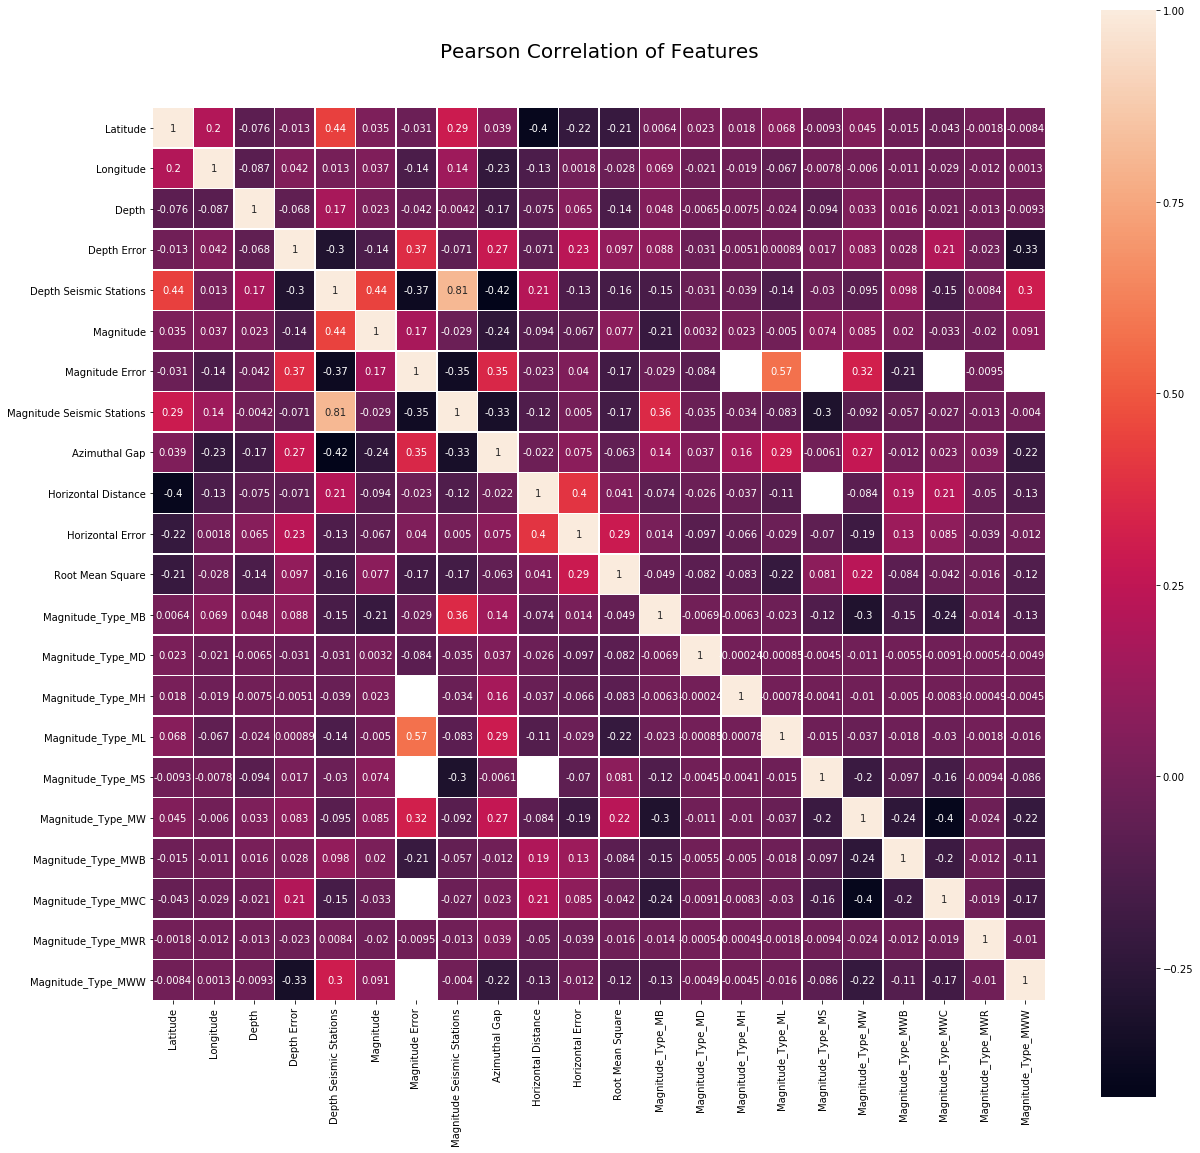

In [11]:
#8
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),linewidths=0.5,vmax=1.0, square=True,linecolor='white', annot=True)
plt.title('Pearson Correlation of Features', y=1.05, size=20)
# plt.savefig('pearson',dpi=300)

缺失的数据实在太多了，与之稍微有些相关的数据也存在缺失的情况，很难通过别的特征计算出缺失的特征

去掉90%以上的数据都缺失的Horizontal以及和它相关的Horizontal Error

In [12]:
#9
data=data.drop(columns=['Horizontal Distance','Horizontal Error'])

将Depth Error和Magnitude Error空缺都补0

In [13]:
#10
data['Depth Error']=data['Depth Error'].fillna(0)
data['Magnitude Error']=data['Magnitude Error'].fillna(0)

因为真的无法找到合适的方法去补全了，将Depth Seismic Stations，Magnitude Seismic Stations补上它们的平均数

In [14]:
#11
data['Depth Seismic Stations']=data['Depth Seismic Stations'].fillna(data['Depth Seismic Stations'].mean())
data['Magnitude Seismic Stations']=data['Magnitude Seismic Stations'].fillna(data['Magnitude Seismic Stations'].mean())

Azimuthal Gap也需要处理，在上面的相关系数图中可以看出来，Azimuthal Gap和Depth Error，Magnitude Error有很大的正相关

In [17]:
#12
X1=data[data['Azimuthal Gap'].notnull()].pivot_table(index=['Depth Error'],values=['Azimuthal Gap']).sort_values('Depth Error',ascending=False)
X2=data[data['Azimuthal Gap'].notnull()].pivot_table(index=['Magnitude Error'],values=['Azimuthal Gap']).sort_values('Magnitude Error',ascending=False)

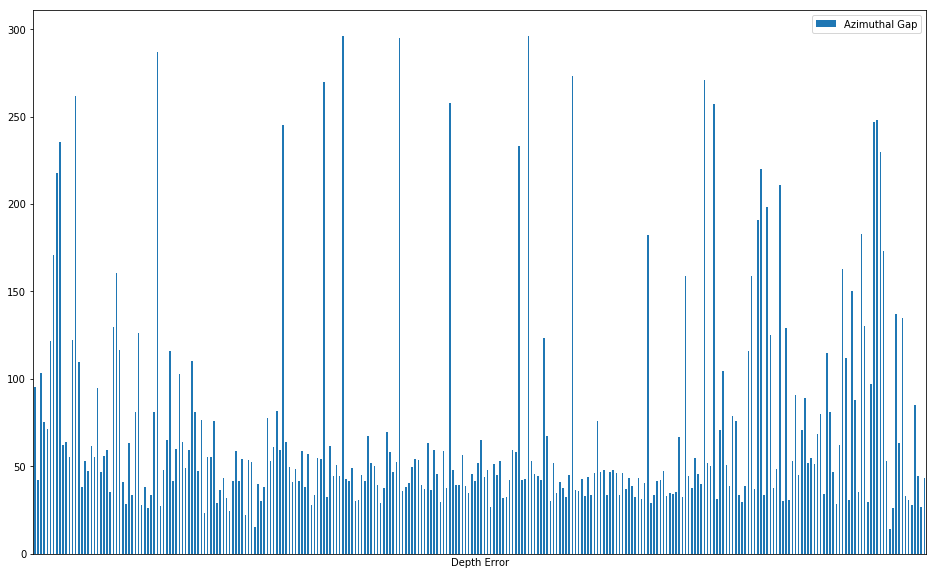

In [19]:
X1.plot(kind='bar',figsize=(16,10))
plt.xticks([])
# plt.savefig('P1',dpi=300)

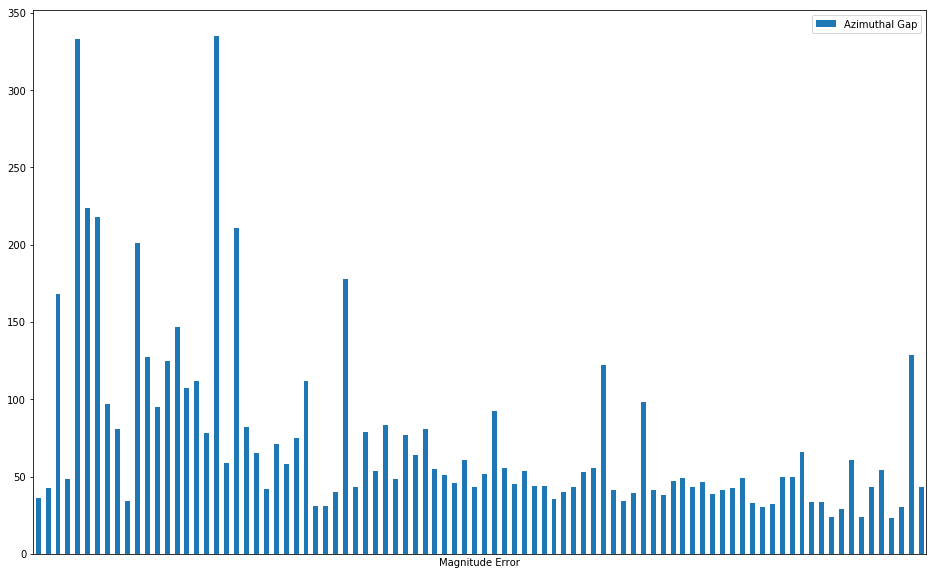

In [20]:
X2.plot(kind='bar',figsize=(16,10))
plt.xticks([])
# plt.savefig('P2',dpi=300)

可以看出，不管是用Depth Error还是Magnitude Error做排序，都不是具有很明显的正相关

Depth Error和Magnitude Error无法作为填补Azimuthal Gap的依据，还是决定用平均值来补充

In [21]:
#13
data['Azimuthal Gap']=data['Azimuthal Gap'].fillna(data['Azimuthal Gap'].mean())

还剩下一个Root Mean Square，这个特殊性，选择众数来进行补充

In [22]:
#14
data['Root Mean Square']=data['Root Mean Square'].fillna(data['Root Mean Square'].mode().shape[0])

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23229 entries, 0 to 23411
Data columns (total 22 columns):
Date                          23229 non-null object
Time                          23229 non-null object
Latitude                      23229 non-null float64
Longitude                     23229 non-null float64
Depth                         23229 non-null float64
Depth Error                   23229 non-null float64
Depth Seismic Stations        23229 non-null float64
Magnitude                     23229 non-null float64
Magnitude Error               23229 non-null float64
Magnitude Seismic Stations    23229 non-null float64
Azimuthal Gap                 23229 non-null float64
Root Mean Square              23229 non-null float64
Magnitude_Type_MB             23229 non-null uint8
Magnitude_Type_MD             23229 non-null uint8
Magnitude_Type_MH             23229 non-null uint8
Magnitude_Type_ML             23229 non-null uint8
Magnitude_Type_MS             23229 non-null uint8
Ma

In [24]:
#15
data=data.reset_index(drop=True)
data.head()

,Date,Time,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,...,Magnitude_Type_MB,Magnitude_Type_MD,Magnitude_Type_MH,Magnitude_Type_ML,Magnitude_Type_MS,Magnitude_Type_MW,Magnitude_Type_MWB,Magnitude_Type_MWC,Magnitude_Type_MWR,Magnitude_Type_MWW
0,01/02/1965,13:44:18,19.246,145.616,131.6,0.0,275.794437,6.0,0.0,47.608943,...,0,0,0,0,0,1,0,0,0,0
1,01/04/1965,11:29:49,1.863,127.352,80.0,0.0,275.794437,5.8,0.0,47.608943,...,0,0,0,0,0,1,0,0,0,0
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,0.0,275.794437,6.2,0.0,47.608943,...,0,0,0,0,0,1,0,0,0,0
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,0.0,275.794437,5.8,0.0,47.608943,...,0,0,0,0,0,1,0,0,0,0
4,01/09/1965,13:32:50,11.938,126.427,15.0,0.0,275.794437,5.8,0.0,47.608943,...,0,0,0,0,0,1,0,0,0,0


到这里为止数据都处理好了

# 下面进行数据分析，放入模型

先将地震发生的地点进行可视化(要很久才运行出来)

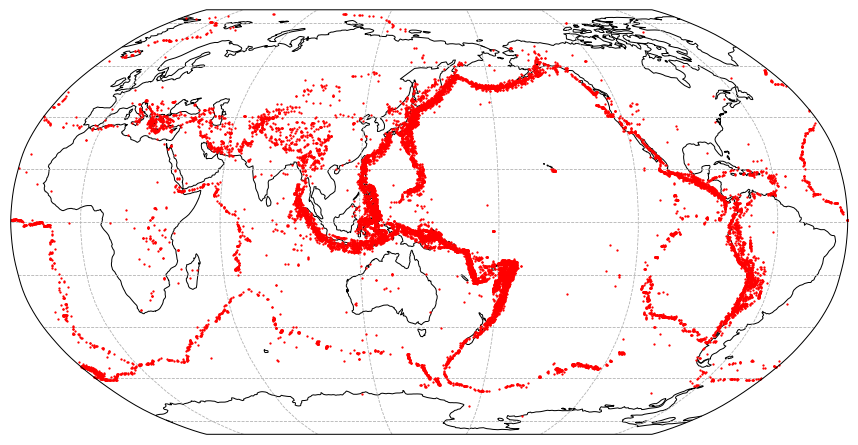

In [25]:
#16
figure1=plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=150))
ax.coastlines()
ax.gridlines(linestyle='--')
for i in data.index.tolist():
    plt.plot(data.loc[i,'Longitude'], data.loc[i,'Latitude'], color='red', marker='.',markersize=2.5,transform=ccrs.Geodetic())
ax.set_global()
plt.show()

可以看出，大多数地震发生在板块的交界处，有些发生在陆地的中央，占少数

In [31]:
#17
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
data_int=data.copy()
data_int['Latitude']=data_int.Latitude.astype(np.int)
data_int['Longitude']=data_int.Longitude.astype(np.int)
data_int=data_int.iloc[:,2:]
temp=pd.concat([data_int,data_int.shift(-1),data_int.shift(-2)],sort=False,axis=1)
#  temp=temp.reset_index(drop=True)
for l in ('Latitude','Longitude'):
    temp2=pd.concat([temp,data_int.shift(-3)[l]],sort=False,axis=1)
    temp2=temp2.iloc[:-3,:]
    # scaler=MinMaxScaler(feature_range=(0,1))
    # temp2=scaler.fit_transform(temp2)
    LR=LinearRegression()
    LR.fit(temp2.iloc[:,:-1],temp2.iloc[:,-1])
    print('LR %s accuracy:%0.2f' % (l,LR.score(temp2.iloc[:,:-1],temp2.iloc[:,-1])))
    gnb = GaussianNB()
    gnb.fit(temp2.iloc[:,:-1],temp2.iloc[:,-1])
    print('gnb %s accuracy:%0.2f' % (l,gnb.score(temp2.iloc[:,:-1],temp2.iloc[:,-1])))

LR Latitude accuracy:0.04
gnb Latitude accuracy:0.01
LR Longitude accuracy:0.03
gnb Longitude accuracy:0.01


就算退一步，将经纬度预测精确到整数，它预测也十分不准确，所以预测到某个地点上是十分不可取的

接下来将地震以经纬度为条件分类，进而预测发生在哪块板块交界处

In [32]:
#18
estimator = KMeans(n_clusters=9)
estimator.fit(data.iloc[:,2:4])
Label=pd.DataFrame(estimator.labels_,columns=['label'])
data_Label=pd.concat([data,Label],sort=False,axis=1)

在地图上显示出来分好的不同交界处(要很久才运行出来)

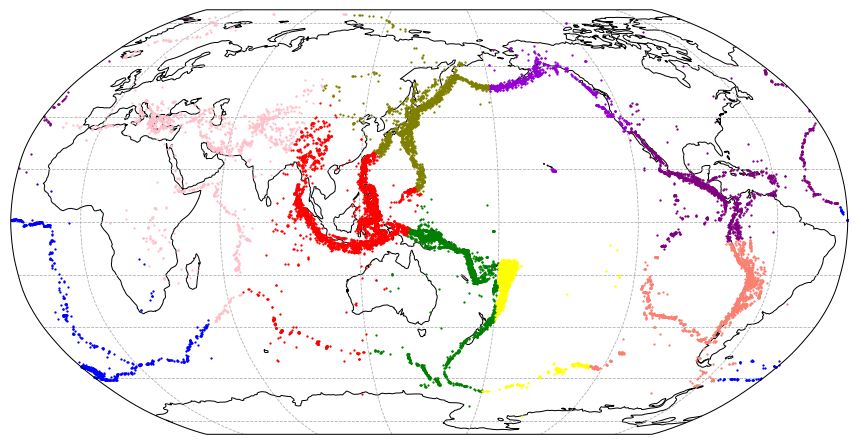

In [33]:
#19
figure1=plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=150))
ax.coastlines()
ax.gridlines(linestyle='--')
for i in data_Label.index.tolist():
    for l,c in zip(range(9),['red','yellow','blue','purple','pink','green','darkviolet','olive','salmon']):
        if data_Label.loc[i,'label']==l:
            plt.plot(data_Label.loc[i,'Longitude'], data_Label.loc[i,'Latitude'], color=c, marker='.',markersize=2.5,transform=ccrs.Geodetic())
ax.set_global()
plt.show()

因为要预测秒数，所以用下面的方法算出相邻两个地震发生时间的时间差，精确到秒数

In [34]:
#20
Time_DataDF=pd.DataFrame()
Time_DataDF['Data_Time']=data['Date'].str.cat(data['Time'],sep=' ')  # 将原数据中的Date和Time结合起来，便于后面运算
Time_DataDF['Data_Time2']=Time_DataDF.shift(1)  # 向下偏移一位，虽然会产生NaN，在后期删了就可以，现在先不删
Time_DataDF['Days']=pd.to_datetime(Time_DataDF.Data_Time)-pd.to_datetime(Time_DataDF.Data_Time2)  # 算出日期差
Time_DataDF['Seconds']=Time_DataDF['Days'].dt.total_seconds()  # 计算到秒数差
data2=pd.concat([data,Time_DataDF['Seconds']],sort=False,axis=1)
data2=pd.concat([data2,Label],sort=False,axis=1)
data2=data2.drop(columns=['Date','Time'])
cols = list(data2)  # 列重排序，将Seconds放到第一个
cols.insert(0,cols.pop(cols.index('Seconds')))
data2=data2.reindex(columns=cols)

将经纬度都变成正数，后面进行归一的时候数据越整齐越好

In [35]:
#21
data2['Latitude']=data2['Latitude']+90
data2['Longitude']=data2['Longitude']+180

第一行数据出现了nan，是上面处理的时候出现的必然问题，把这行去掉

In [36]:
#22
data2=data2.drop([0])
data2=data2.reset_index(drop=True)
data2.head()

,Seconds,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,...,Magnitude_Type_MD,Magnitude_Type_MH,Magnitude_Type_ML,Magnitude_Type_MS,Magnitude_Type_MW,Magnitude_Type_MWB,Magnitude_Type_MWC,Magnitude_Type_MWR,Magnitude_Type_MWW,label
0,164731.0,91.863,307.352,80.0,0.0,275.794437,5.8,0.0,47.608943,43.80898,...,0,0,0,0,1,0,0,0,0,0
1,110169.0,69.421,6.028,20.0,0.0,275.794437,6.2,0.0,47.608943,43.80898,...,0,0,0,0,1,0,0,0,0,1
2,261825.0,30.924,156.443,15.0,0.0,275.794437,5.8,0.0,47.608943,43.80898,...,0,0,0,0,1,0,0,0,0,2
3,67387.0,101.938,306.427,15.0,0.0,275.794437,5.8,0.0,47.608943,43.80898,...,0,0,0,0,1,0,0,0,0,0
4,86622.0,76.595,346.629,35.0,0.0,275.794437,6.7,0.0,47.608943,43.80898,...,0,0,0,0,1,0,0,0,0,5


接下来训练模型，并用训练好的模型预测下一次地震的时间，震级

用与上面同样的方法，前三次数据当作训练数据，后一次数据当结果去练习

In [41]:
#23
data_for_train=pd.DataFrame()
data_for_train=pd.concat([data2,data2.shift(-1),data2.shift(-2)],sort=False,axis=1)
result_list=[]
for l in ('Seconds','Magnitude'):
    data_for_train2=pd.concat([data_for_train,data2[l].shift(-3)],sort=False,axis=1)
    data_for_train2=data_for_train2.iloc[:-2,:]
    train=data_for_train2
    #data_for_train2.iloc[-1,-1]=0
    #scaler = MinMaxScaler(feature_range=(0,1))
    #train=scaler.fit_transform(data_for_train2)
    LR=LinearRegression()  # 用线性回归去预测下次发生的时间和震级
    LR.fit(train.iloc[:-1,:-1],train.iloc[:-1,-1])
    result=LR.predict(np.array(train.iloc[-1,:-1]).reshape(1,-1))
    #train[-1,-1]=result
    #back=scaler.inverse_transform(train)
    result_list.append(round(result[0]))
    print('Predict %s : %0.1f' %(l,result[0]))

Predict Seconds : 12342.9
Predict Magnitude : 6.0


然后预测地震发生的板块交界处

In [42]:
#24
RFC=RandomForestClassifier(n_estimators=200,max_depth=20)  # 运用随机森林预测下次发生的区域
data_for_train2=pd.concat([data_for_train,data2['label'].shift(-3)],sort=False,axis=1)
data_for_train2=data_for_train2.iloc[:-2,:]
RFC.fit(data_for_train2.iloc[:-1,:-1],data_for_train2.iloc[:-1,-1])
label_result=RFC.predict(np.array(data_for_train2.iloc[-1,:-1]).reshape(1,-1))
result_list.append(label_result[0])
score=RFC.score(data_for_train2.iloc[:-1,:-1],data_for_train2.iloc[:-1,-1])
print('Precict Label: %0.1f' %(label_result[0]))
print('Label Accuracy:%0.2f' %(score))

Precict Label: 7.0
Label Accuracy:0.99


得到三个结果

In [43]:
#25
result_list

[12343.0, 6.0, 7.0]

将预测的结果完美展示出来（因为要画图，需要运行很久）

Time:2016-12-30 23:34:11 Magnitude:6.0


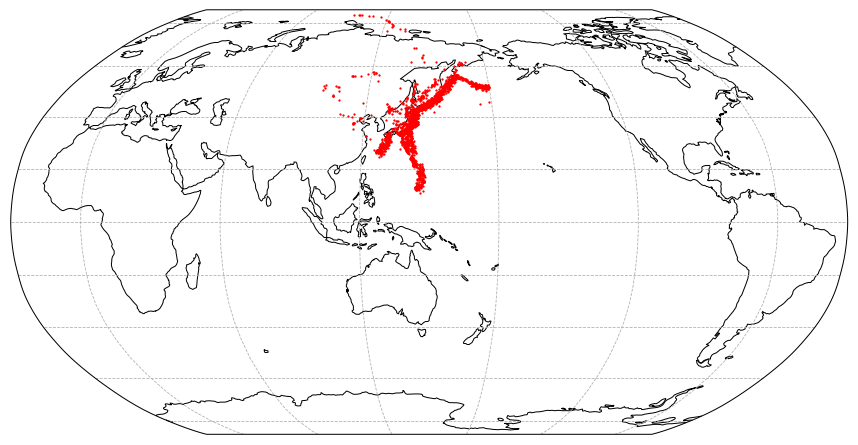

In [44]:
#26
Time_result=str(pd.to_datetime(Time_DataDF.iloc[-1,0])+datetime.timedelta(0,result_list[0],0))  # 最后发生的时间加上间隔，就是下次发生的时间
print('Time:%s Magnitude:%s' %(Time_result,result_list[1]))

figure1=plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=150))
ax.coastlines()
ax.gridlines(linestyle='--')
for i in data_Label.index.tolist():
    if data_Label.loc[i,'label']==result_list[2]:
        plt.plot(data_Label.loc[i,'Longitude'], data_Label.loc[i,'Latitude'], color='red', marker='.',markersize=2.5,transform=ccrs.Geodetic())
ax.set_global()
plt.show()

以上就是预测的下一次地震发生的时间，震级和所处的板块交界处

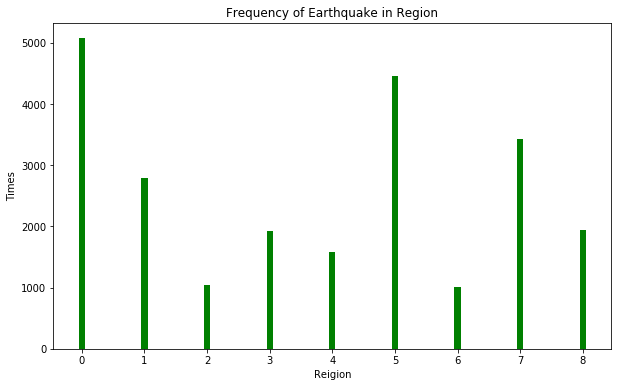

In [46]:
#27
plt.figure(figsize=(10,6))  
for i1 in range(9):
    y=0
    for i2 in data2.index.tolist():
        if data2.loc[i2,'label']==i1:
            y=y+1
    plt.bar(i1,y,0.1,color='green')

plt.xlabel('Reigion')
plt.ylabel('Times')
plt.title('Frequency of Earthquake in Region') 
# plt.savefig('p3',dpi=300)
plt.show() 

可以看到，预测的是会发生在的区域是发生次数前三多的

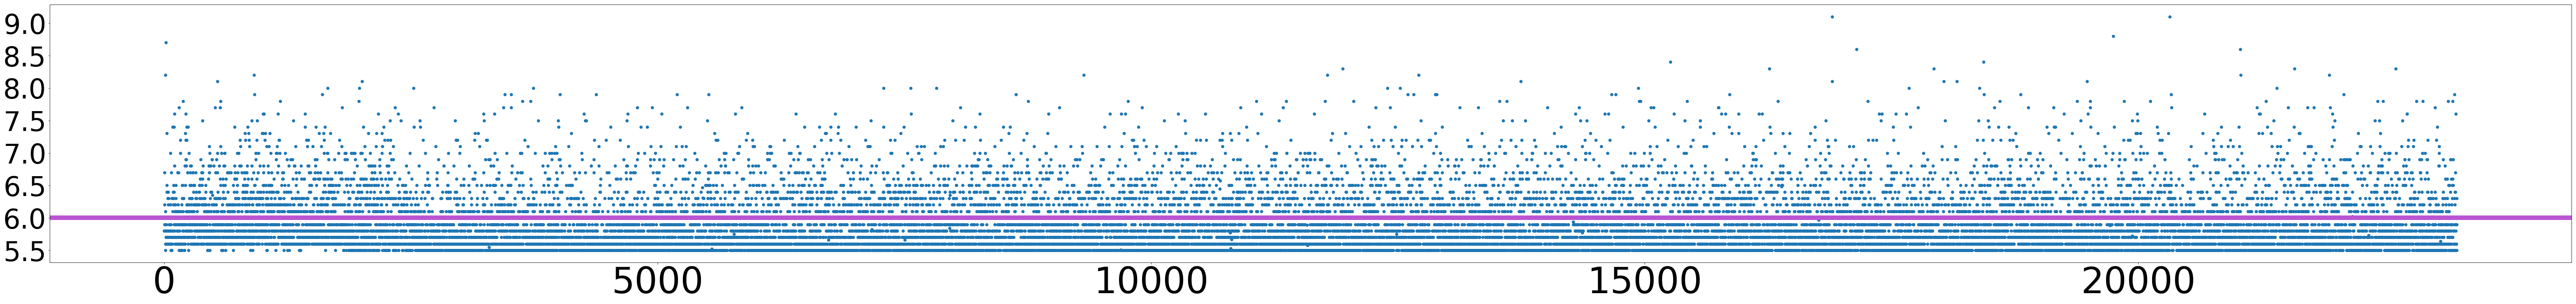

In [52]:
#28
plt.figure(figsize=(100,10.5))
x=range(len(data2))
y=np.array(data2.loc[:,'Magnitude'])
plt.scatter(x,y)
plt.axhline(6.0,color='#BA55D3',linewidth=10)
plt.xticks(fontsize=80)
plt.yticks(fontsize=60)
# plt.savefig('p4',dpi=300)
plt.show()

这样看来6.0作为预测震级还是很可信的

综上，预测结果还是有一定的意义的